Mounting the fastai platform on Google Drive


In [1]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


Mount the Google Drive on Colab

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Convert all the .jfif files to jpeg to ensure consistency


In [0]:
# !sudo apt install imagemagick
# !cd '/content/gdrive/My Drive/fastai-v3/wheat_rust/test/'; mogrify -format jpg *.jfif
# !cd '/content/gdrive/My Drive/fastai-v3/wheat_rust/train/healthy_wheat'; mogrify -format jpg *.jfif  
# !cd '/content/gdrive/My Drive/fastai-v3/wheat_rust/train/leaf_rust'; mogrify -format jpg *.jfif  
# !cd '/content/gdrive/My Drive/fastai-v3/wheat_rust/train/stem_rust'; mogrify -format jpg *.jfif  

Import the required libraries

In [0]:
from fastai.vision import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


Define the path on Google Drive


In [24]:
path = Path(base_dir + 'wheat_rust/')
path.ls()



[PosixPath('/content/gdrive/My Drive/fastai-v3/wheat_rust/train'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/wheat_rust/test'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/wheat_rust/starter_nb_submission.csv')]

Create the ImageDataBunch from the folders on Google Drive

In [26]:
np.random.seed(42)

data = ImageDataBunch.from_folder( path/'train', train='.', test='../test'
               , valid_pct=0.2, bs=64, size=224, ds_tfms=get_transforms())
data.classes

['healthy_wheat', 'leaf_rust', 'stem_rust']

View random sample of the images

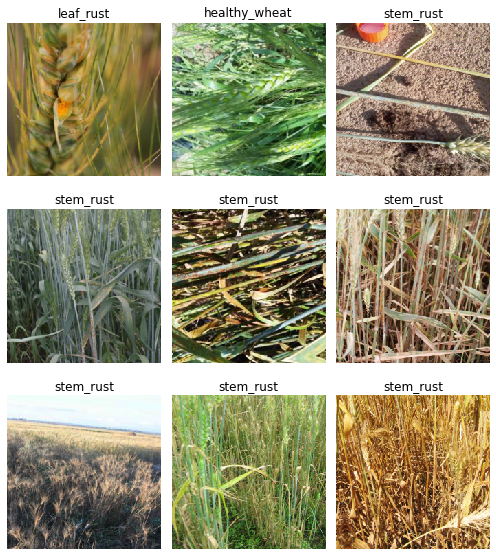

In [0]:
data.show_batch(rows=3, figsize=(7,8))

Build the Learner

In [0]:
w = torch.cuda.FloatTensor([1.0, 0.9, 1.1])
learn = cnn_learner(data, models.resnet34, metrics = error_rate, loss_func=torch.nn.CrossEntropyLoss(weight=w))


In [ ]:
learn.lr_find()
learn.recorder.plot()

Fit the top layer of the model

In [28]:
learn.fit_one_cycle(40,max_lr=slice(1e-3,1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,1.713520,1.164299,0.405714,00:09
1,1.316369,0.906857,0.285714,00:08
2,1.088223,0.623442,0.211429,00:08
3,0.917596,0.524744,0.182857,00:08
4,0.823080,0.483814,0.165714,00:08


Save the stage-1 of the model

In [0]:
learn.save('stage-1')

Unfreeze the transfer learning model so better results can be obtained


In [0]:
learn.unfreeze()

Finding the optimum learning rate

In [31]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Determine the best from the plot

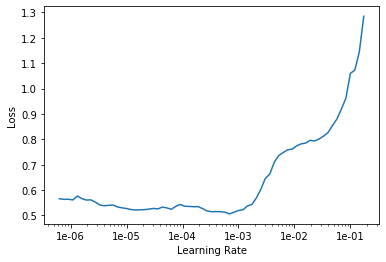

In [32]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

Re-fitting the model for deeper layers

In [33]:
learn.fit_one_cycle(4, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.498677,0.475156,0.165714,00:09
1,0.519410,0.473621,0.177143,00:09
2,0.490924,0.438371,0.177143,00:09
3,0.465943,0.436742,0.165714,00:08


In [0]:
learn.save('stage-2')

Load the new saved model

In [0]:
learn.load('stage-2');

Interpreting the model

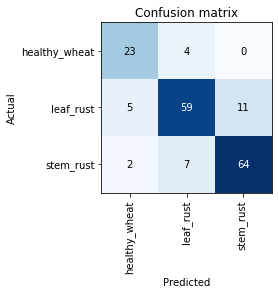

In [36]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


Making predictions on the test dataset

In [37]:
learn.export()
preds, y = learn.get_preds(ds_type=DatasetType.Test)



Save Predictions

In [38]:
import os

submission = pd.DataFrame({'ID': [s.split('.')[0] for s in os.listdir('/content/gdrive/My Drive/fastai-v3/wheat_rust/test/')  if s.split('.')[1] != 'jfif']})
for i, c in enumerate(learn.data.classes):
  submission[c] = preds[:,i]
submission = submission[['ID', 'leaf_rust', 'stem_rust', 'healthy_wheat']] # Get same order as sample sub
submission.head()


,ID,leaf_rust,stem_rust,healthy_wheat
0,1NCGYL,0.974732,0.022471,0.002797
1,0JIX2C,0.000129,0.999849,0.000022
2,008FWT,0.012044,0.965214,0.022742
3,26MSDN,0.904330,0.088019,0.007651
4,00AQXY,0.133757,0.860357,0.005886


In [40]:
print(len(submission))
submission.to_csv('/content/gdrive/My Drive/fastai-v3/wheat_rust/starter_nb_submission.csv', index=False)

620
